In [1]:
import argparse
import torch
import wandb
import numpy as np
from dassl.utils import setup_logger, set_random_seed, collect_env_info
from dassl.config import get_cfg_default
from dassl.engine import build_trainer
from sklearn.mixture import BayesianGaussianMixture
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /mnt/disk1/anaconda3/envs/ndg2/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefINS2_6SymIntEEENS2_8optionalINS2_10ScalarTypeEEENS6_INS2_6LayoutEEENS6_INS2_6DeviceEEENS6_IbEENS6_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")


In [2]:
def reset_cfg(cfg, args):
    if args.root:
        cfg.DATASET.ROOT = args.root

    if args.output_dir:
        cfg.OUTPUT_DIR = args.output_dir

    if args.resume:
        cfg.RESUME = args.resume

    if args.seed:
        cfg.SEED = args.seed

    if args.source_domains:
        cfg.DATASET.SOURCE_DOMAINS = args.source_domains

    if args.target_domains:
        cfg.DATASET.TARGET_DOMAINS = args.target_domains

    if args.transforms:
        cfg.INPUT.TRANSFORMS = args.transforms

    if args.trainer:
        cfg.TRAINER.NAME = args.trainer

    if args.backbone:
        cfg.MODEL.BACKBONE.NAME = args.backbone

    if args.head:
        cfg.MODEL.HEAD.NAME = args.head

    #if args.uncertainty:
    cfg.MODEL.UNCERTAINTY = args.uncertainty

    #if args.pos:
    cfg.MODEL.POS = args.pos
    cfg.USE_CUDA = False
    
def setup_cfg(args):
    cfg = get_cfg_default()
    reset_cfg(cfg, args)
    if args.dataset_config_file:
        cfg.merge_from_file(args.dataset_config_file)
    if args.config_file:
        cfg.merge_from_file(args.config_file)
    cfg.merge_from_list(args.opts)
    cfg.freeze()
    return cfg

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument('--root', type=str, default='./DATA', help='path to dataset')
parser.add_argument(
    '--output-dir', type=str, default='../output/dg/pacs/baseline/sketch', help='output directory'
)
parser.add_argument(
    '--resume',
    type=str,
    default='',
    help='checkpoint directory (from which the training resumes)'
)
parser.add_argument(
    '--seed',
    type=int,
    default=1,
    help='only positive value enables a fixed seed'
)
parser.add_argument(
    '--source-domains',
    type=str,
    nargs='+',
    default='art_painting photo cartoon'.split(),
    help='source domains for DA/DG'
)
parser.add_argument(
    '--target-domains',
    type=str,
    nargs='+',
    default=['sketch'],
    help='target domains for DA/DG'
)
parser.add_argument(
    '--transforms', type=str, nargs='+', help='data augmentation methods'
)
parser.add_argument(
    '--config-file', type=str, default='../configs/trainers/dg/vanilla/pacs.yaml', help='path to config file'
)
parser.add_argument(
    '--dataset-config-file',
    type=str,
    default='../configs/datasets/dg/pacs.yaml',
    help='path to config file for dataset setup'
)
parser.add_argument(
    '--trainer', type=str, default='Vanilla', help='name of trainer'
)
parser.add_argument(
    '--backbone', type=str, default='', help='name of CNN backbone'
)
parser.add_argument('--head', type=str, default='', help='name of head')
parser.add_argument(
    '--eval-only', action='store_true', help='evaluation only'
)
parser.add_argument(
    '--model-dir',
    type=str,
    default='',
    help='load model from this directory for eval-only mode'
)
parser.add_argument(
    '--load-epoch',
    type=int,
    help='load model weights at this epoch for evaluation'
)
parser.add_argument(
    '--no-train', action='store_true', help='do not call trainer.train()'
)
parser.add_argument(
    'opts',
    default=None,
    nargs=argparse.REMAINDER,
    help='modify config options using the command-line'
)
parser.add_argument('--uncertainty', default=0.0, type=float)
parser.add_argument('--pos', nargs='+', type=int, default=[],
                    help='pos for uncertainty')
parser.add_argument('--wandb', default=0, type=int, help='visualize on Wandb')
parser.add_argument('--option', default='', type=str, help='additional options')
parser.add_argument('--update_interval', default=20, type=int, help='update cluster interval')

args = parser.parse_args('')

In [4]:
cfg = setup_cfg(args)
if args.wandb:
    if 'u' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'DSU'
    elif 'c' in cfg.MODEL.BACKBONE.NAME:
        job_type = 'ConstStyle'
    else:
        job_type = 'Baseline'
    if cfg.MODEL.BACKBONE.PRETRAINED:
        job_type += '-pretrained'
        
    tracker = wandb.init(
        project = 'StyleDG',
        entity = 'aiotlab',
        config = args,
        group = f'{cfg.DATASET.NAME}',
        name = f'train={cfg.DATASET.SOURCE_DOMAINS}_test={cfg.DATASET.TARGET_DOMAINS}_type={args.option}',
        job_type = job_type
    )
    args.tracker = tracker

if cfg.SEED >= 0:
    print('Setting fixed seed: {}'.format(cfg.SEED))
    set_random_seed(cfg.SEED)
setup_logger(cfg.OUTPUT_DIR)

if torch.cuda.is_available() and cfg.USE_CUDA:
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

trainer = build_trainer(cfg, args)
device = torch.device('cpu')
trainer.model.backbone.to(device)

Setting fixed seed: 1
Loading trainer: Vanilla
Loading dataset: PACS
Train dataset statistics| Domain [0 1 2] - count [1840 1499 2107] | Class: [0 1 2 3 4 5 6] - count [ 861  821  730  453  650  775 1156]
Test dataset statistics| Domain [0] - count [3928] | Class: [0 1 2 3 4 5 6] - count [771 740 753 608 816  80 160]
Building transform_train
+ resize to 224x224
+ random flip
+ random translation
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
Building transform_test
+ resize to 224x224
+ to torch tensor of range [0, 1]
+ normalization (mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
***** Dataset statistics *****
  Dataset: PACS
  Source domains: ['art_painting', 'photo', 'cartoon']
  Target domains: ['sketch']
  # classes: 7
  # train_x: 5,446
  # val: 616
  # test: 3,928
Building model
Backbone: resnet18
# params: 11,180,103
Loading evaluator: Classification


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
trainer.load_model(cfg.OUTPUT_DIR, epoch=50)

Loading weights to model from "../output/dg/pacs/baseline/sketch/model/model.pth.tar-50" (epoch = 50)
torch.Size([19, 3, 224, 224])
torch.Size([15, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([18, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([22, 3, 224, 224])
torch.Size([21, 3, 224, 224])
torch.Size([12, 3, 224, 224])
torch.Size([18, 3, 224, 224])
torch.Size([26, 3, 224, 224])
torch.Size([14, 3, 224, 224])
torch.Size([20, 3, 224, 224])
torch.Size([28, 3, 224, 224])
torch.Size([27, 3, 224, 224])
torch.Size([29, 3, 224, 224])
torch.Size([15, 3, 224, 224])
torch.Size([18, 3, 224, 224])
torch.Size([24, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([15, 3, 224, 224])
torch.Size([23, 3, 224, 224])
torch.Size([21, 3, 224, 224])
torch.Size([25, 3, 224, 224])
torch.Size([19, 3, 224, 224])
torch.Size([16, 3, 224, 224])
torch.Size([17, 3, 224, 224])
torch.Size([26, 3, 224, 224])
torch.Size([23, 3, 224, 224]

In [47]:
chosen_class = 5
target_layers = [trainer.model.backbone.layer4[-1]]
cam = ScoreCAM(model=trainer.model, target_layers=target_layers)
targets = [ClassifierOutputTarget(chosen_class)]

100%|██████████| 32/32 [01:26<00:00,  2.72s/it]


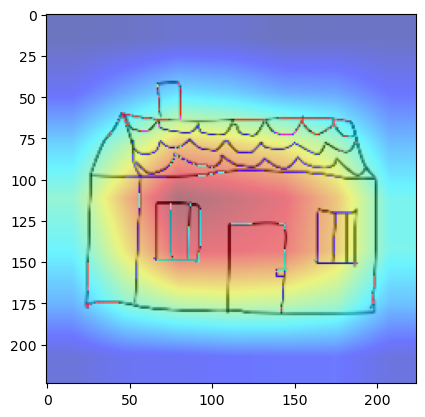

100%|██████████| 32/32 [00:53<00:00,  1.68s/it]


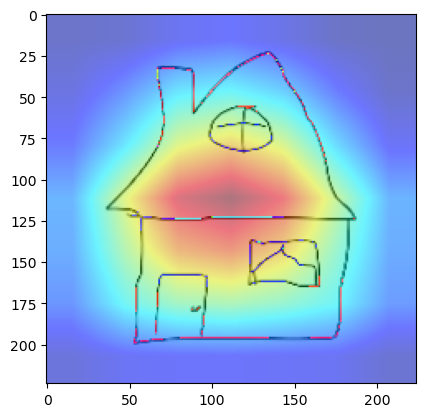

In [49]:
for batch in trainer.test_loader:
    images, label = trainer.parse_batch_test(batch)
    selected_images = images[label == chosen_class]
    if selected_images.shape[0] == 0:
        continue
    random_images = torch.unsqueeze(selected_images[1], dim=0)
    grayscale_cam = cam(input_tensor=random_images, targets=targets)
    grayscale_cam = grayscale_cam[0, :]
    input_tensor = np.squeeze(random_images.numpy())
    input_tensor /= np.max(input_tensor)
    input_tensor = np.transpose(input_tensor, (1, 2, 0))
    visualization = show_cam_on_image(input_tensor, grayscale_cam, use_rgb=True)
    # visualization = np.transpose(selected_images[0], (1, 2, 0))
    plt.imshow(visualization)
    plt.show()
    plt.close()